# Question 3
"Collect your own data about a few homes around a neighborhood which are for sale. For example, collect data on sq. ft. per floor separately from the basement, if any, number of bedrooms, number of bathrooms, sq. ft living, if it has a pool or not, number of car
garages, etc. Be very descriptive on your choices, what kind of data you collected for analysis and how many. Then use LASSO by employing the coordinate descent algorithm to analyze the data with price being the response variable. Write down the necessary LASSO optimization equations and its coordinate descent algorithmic implementation. Attempt to be as detailed as possible, and then report on your findings using layman’s words [Friendly Advice: do not forget this problem when you buy your own house in the future :) ]."

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error

I chose to look at houses in Colorado Springs, Colorado because this is a place I could see myself living in the next 10 years. I picked the following variables for each house to include in my analysis:

1. Price (in US dollars)
2. Square feet (of the entire house)
3. Number of Bedrooms
4. Number of Bathrooms
5. Number of Garage Spaces (i.e. 1, 2, 3, etc. car garage)

I will print out some statistics about the housing data I collected in the cell below:

In [78]:
housing_data = pd.read_excel("CS_housing.xlsx")

# Building X and y for the Lasso model
X = housing_data.copy()
X.drop(labels = "Price", axis = 1, inplace = True)
X = X.to_numpy()
y = housing_data["Price"].to_numpy()

print(housing_data.describe())

              Price          Sqft        Bed       Bath     Garage
count  5.000000e+01     50.000000  50.000000  50.000000  50.000000
mean   7.917187e+05   3382.260000   3.720000   3.310000   2.340000
std    9.983404e+05   2685.923881   1.107304   1.809527   1.318781
min    6.500000e+04    576.000000   2.000000   1.000000   0.000000
25%    3.061750e+05   1587.750000   3.000000   2.000000   2.000000
50%    4.214500e+05   2776.500000   4.000000   3.000000   2.000000
75%    6.497500e+05   3864.250000   4.000000   4.000000   3.000000
max    4.555000e+06  13103.000000   7.000000  10.000000   6.000000


## Lasso 

Lasso is an algorithm that can be applied to build regression models. The algorithm attempts to minimize the following cost function:

$$f(x) = \frac{1}{2} ||Ax - b||^2_2 + \lambda * ||x||_1 $$

Where $||x||_2$ denotes the $L^2$ norm of $x$ and $||x||_1$ denotes the $L^1$ norm of $x$. The $\frac{1}{2} ||Ax - b||^2_2$ term corresponds to the sum of squares. The $\lambda * ||x||_1$ term penalizes the model for including a large variety of estimators. As a result of this term, the lasso favors a simpler model with less estimators. It is important to note that if $\lambda = 0$, this becomes a simple least-squares regression method.

This method differs from ridge regression in that it uses the $L^1$ norm in the penalty term instead of the $L^2$ norm (as ridge regression does). As a result, unlike ridge regression, lasso practically allows the model to ignore certain variables entirely, creating a simpler model.

![l1vl2](https://upload.wikimedia.org/wikipedia/en/f/fd/L1_and_L2_balls.jpg)

For running this algorithm, I will use the SciKit-Learn implementation. This implementation uses $\alpha$ as the penalty weight instead of $\lambda$ as is discussed above. 

To determine the proper $\lambda$ (or $\alpha$) value, we will use cross validation. As a measure of performance, we will use the mean squared error metric.

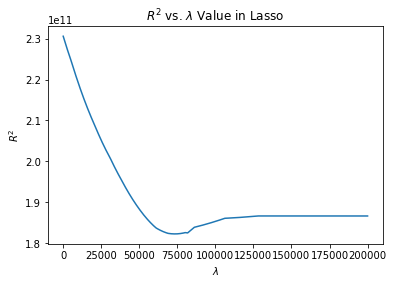

In [79]:
alpha_tries = np.linspace(0.25, 200000, 500)

avg_score = []

for a in alpha_tries:
    cross_val = KFold(n_splits = 5)
    cv_iter = cross_val.split(X, y)
    
    split_r2 = []
    
    # Evaluate each split
    for train, test in cv_iter:
        lasso_model = Lasso(alpha = a)
        lasso_model.fit(X[train], y[train])
        #split_r2.append(lasso_model.score(X[test], y[test]))
        
        split_r2.append(mean_squared_error(lasso_model.predict(X[test]), y[test]))
        
    avg_score.append(np.mean(split_r2))
    
plt.plot(alpha_tries, avg_score)
plt.title("$R^2$ vs. $\lambda$ Value in Lasso")
plt.xlabel("$\lambda$")
plt.ylabel("$R^2$")
plt.show()

From these results, it suggest that we should pick an alpha value around 70,000 (the minimum of the curve) to construct the full model:

In [80]:
lasso_model = Lasso(alpha = 70000)
lasso_model.fit(X, y)
c = lasso_model.coef_

print("Sqft coefficient \t = ", c[0])
print("Bed coefficient \t = ", c[1])
print("Bath coefficient \t = ", c[2])
print("Garage coefficient \t = ", c[3])
print("Intercept \t\t = ", lasso_model.intercept_)

Sqft coefficient 	 =  365.9436131905292
Bed coefficient 	 =  -74488.12474076796
Bath coefficient 	 =  0.0
Garage coefficient 	 =  -0.0
Intercept 		 =  -168901.94111414242


From these coefficients, we can observe several phenomena:
    
1. Number of bathrooms and garages has become zero
    - This has happened because, as previously discussed, the lasso may completely cancel out some coefficients in the model if they do not provide sufficient improvement to the predictions. When I was gathering the data, I noticed that the number of cars that can go in a garage and the price of the home did seem to have a very weak correlation. Quantitatively, this correlation must be very weak for lasso to completely cancel out the term.
    
2. Number of bedrooms has a negative coefficient
    - This is most likely because there is not a strong correlation between number of bedrooms and price, so the lasso attempted to offset this variable by setting the coefficient to be very negative.
    
3. In comparison, square-footage seems to have a smaller effect on the price of a home
    - Practically, this result makes sense. A large home in a cheap neighborhood may be just as expensive as a small home in an expensive neighborhood. This argument could be made for any of the other variables, but since square footage is less discrete (can take on more values as it is in the >1000 order of magnitude), we see square footage having a smaller coefficient.
    - This small value could be due to the lasso's tendency to minimize terms to minimize coefficients of as many variables as it can. 
    
Overall, the lasso is a sophisticated regression technique that can be used to predict housing prices. The model I was able to build may not be very accurate, but that may be because I mainly analyzed expensive homes in Colorado Springs, CO.